In [1]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from yellowbrick.regressor import ResidualsPlot

In [2]:
cars_data = pd.read_excel("data/Cars_Data_full.xlsx")

In [3]:
cars_data.head()

,Price,Age,KM,Fuel,HP,MC,Color,Auto,CC,Drs,...,AC,Comp,CD,Clock,Pwin,PStr,Radio,SpM,M_Rim,Tow_Bar
0,21000,26,31463,Petrol,195,0,Silver,0,1800,3,...,1,0,1,1,1,1,0,0,1,0
1,20000,23,43612,Petrol,195,0,Red,0,1800,3,...,1,1,0,1,1,1,0,1,1,0
2,19650,26,32191,Petrol,195,0,Red,0,1800,3,...,1,1,0,1,1,1,0,1,1,0
3,21550,32,23002,Petrol,195,1,Black,0,1800,3,...,1,1,1,1,1,1,0,1,1,0
4,22550,33,34133,Petrol,195,1,Grey,0,1800,3,...,1,1,1,1,1,1,0,1,1,0


In [4]:
cars_data.shape#y = (y / 10000) # no benefit from reducing scale

(1367, 28)

## Create X and y

Feature selection based on kendall correlation statistic

In [5]:
X = cars_data.loc[(cars_data['Price'] > 6000.0) & (cars_data['Price'] < 22000.0)]
y = X.pop('Price')


In [6]:
numerical_features = cars_data.columns[cars_data.dtypes.apply(lambda x: x in ('int64', 'float64'))]
categorical_features = cars_data.columns[cars_data.dtypes.apply(lambda x: x == 'object')]

In [7]:
corr_mat = cars_data[numerical_features].corr(method='kendall')
corr_mat.drop('Price', inplace=True)

Text(0, 0.5, 'Correlation')

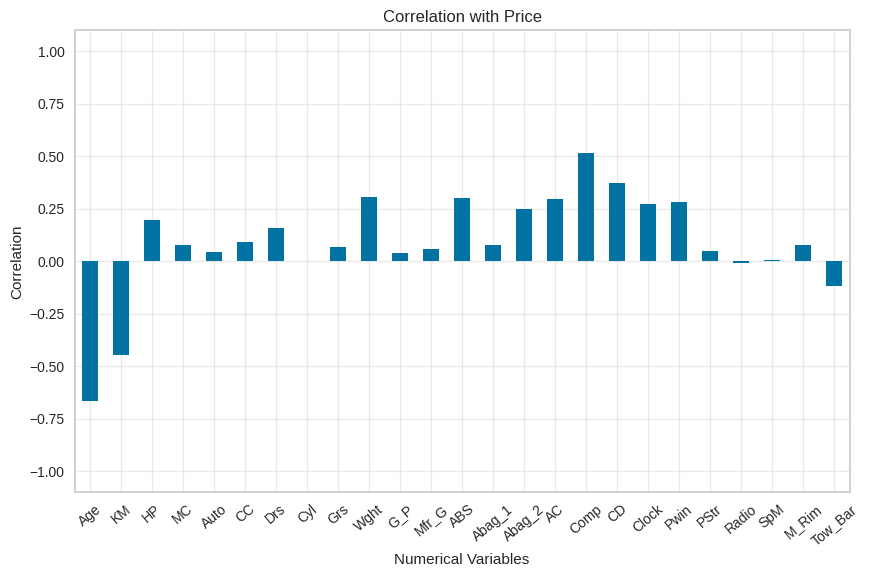

In [8]:
ax = corr_mat['Price'].plot(kind='bar', figsize=(10, 6))
ax.set_ylim(-1.1, 1.1)
ax.grid(alpha=0.4)
for item in ax.xaxis.get_ticklabels():
    item.set_rotation(40)

ax.set_title("Correlation with Price")
ax.set_xlabel("Numerical Variables")
ax.set_ylabel("Correlation")

In [9]:
numerical_features = corr_mat['Price'][corr_mat['Price'].abs() > 0.1].index.tolist()
numerical_features

['Age',
 'KM',
 'HP',
 'Drs',
 'Wght',
 'ABS',
 'Abag_2',
 'AC',
 'Comp',
 'CD',
 'Clock',
 'Pwin',
 'Tow_Bar']

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
#from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Feature Engineering

In [11]:
numerical_features = corr_mat['Price'][corr_mat['Price'].abs() > 0.1].index.tolist()
categorical_features = cars_data.columns[cars_data.dtypes.apply(lambda x: x == 'object')]

In [12]:
# transfomrer for numerical data
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


# transformer for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)


# combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ], verbose_feature_names_out=True
)

## train-test splits

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41232)

In [14]:
X_train = preprocessor.fit_transform(X_train, y_train)

In [15]:
X_test = preprocessor.transform(X_test)

## Model selection with CV

In [16]:
param_grid = dict(n_estimators=[120], 
                  colsample_bytree=[0.8], 
                  subsample=[0.8] , 
                  subsample_freq=[1],
                  learning_rate = [0.2],
                  max_depth = [2, 3],
                  num_leaves = [2, 4, 10],
                  reg_alpha = [0.1, 0.2, 0.3],
                  reg_lambda = [0.1, 0.2, 0.3])

In [17]:
start= datetime.datetime.now()

grid_search = GridSearchCV(
        estimator=lgb.LGBMRegressor(n_jobs=-1, force_row_wise=True, verbosity=-1),
        param_grid=param_grid,
        return_train_score=True,
        cv=5, 
        scoring='r2', 
        n_jobs=-1, 
        verbose=0
    ).fit(X_train, y_train)

end = datetime.datetime.now()

In [18]:
print("Duration: {}".format(end-start), end, start)

Duration: 0:01:23.223535 2023-10-08 20:25:15.105394 2023-10-08 20:23:51.881859


In [19]:
est = grid_search.best_estimator_
print(est)

LGBMRegressor(colsample_bytree=0.8, force_row_wise=True, learning_rate=0.2,
              max_depth=3, n_estimators=120, n_jobs=-1, num_leaves=4,
              reg_alpha=0.3, reg_lambda=0.1, subsample=0.8, subsample_freq=1,
              verbosity=-1)


In [20]:
est.score(X_test, y_test)

0.8950385274774673

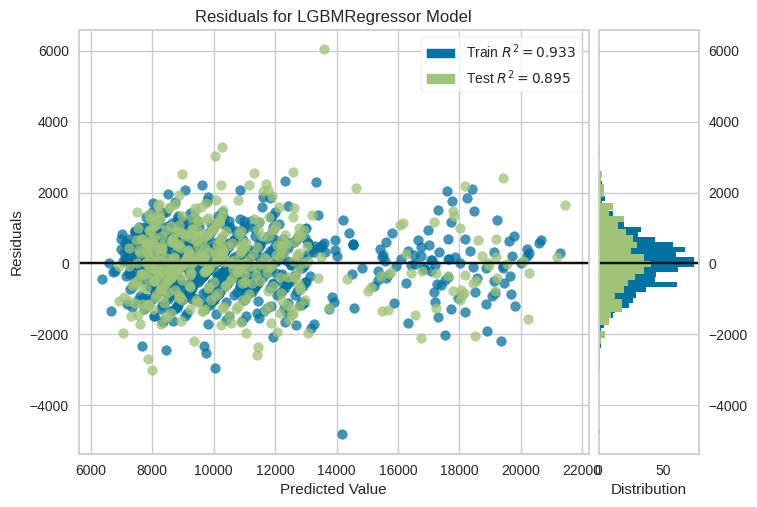

<Axes: title={'center': 'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [21]:
visualizer = ResidualsPlot(estimator=est)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [22]:
y_test_pred = est.predict(X_test)
y_test_pred.shape

(436,)

In [23]:
pred_df = y_test.to_frame('y_test')
pred_df['y_pred'] = y_test_pred

In [24]:
pred_df['error'] = (pred_df['y_test'] - pred_df['y_pred']).abs()

In [25]:
pred_df.sort_values(by='error', ascending=False, inplace=True)
pred_df.head()

,y_test,y_pred,error
555,7550,13586.678027,6036.678027
602,7000,10277.570175,3277.570175
772,7000,10029.558058,3029.558058
1315,11000,8005.840465,2994.159535
1000,10550,7849.141065,2700.858935


In [26]:
cars_data.loc[pred_df.head().index]

,Price,Age,KM,Fuel,HP,MC,Color,Auto,CC,Drs,...,AC,Comp,CD,Clock,Pwin,PStr,Radio,SpM,M_Rim,Tow_Bar
555,7550,51,3,Diesel,93,1,Green,0,2000,3,...,0,0,0,1,1,1,1,0,1,1
602,7000,66,114385,Diesel,93,0,White,0,2000,3,...,0,0,0,0,0,1,0,0,0,0
772,7000,59,69024,Petrol,89,1,Black,0,1300,5,...,0,0,1,1,0,1,0,1,0,0
1315,11000,77,53135,Petrol,113,1,Green,0,1600,5,...,0,0,0,0,0,1,0,1,0,0
1000,10550,78,172982,Diesel,75,1,Black,0,2000,5,...,0,0,0,0,0,1,0,0,0,0


<Axes: xlabel='y_pred', ylabel='y_test'>

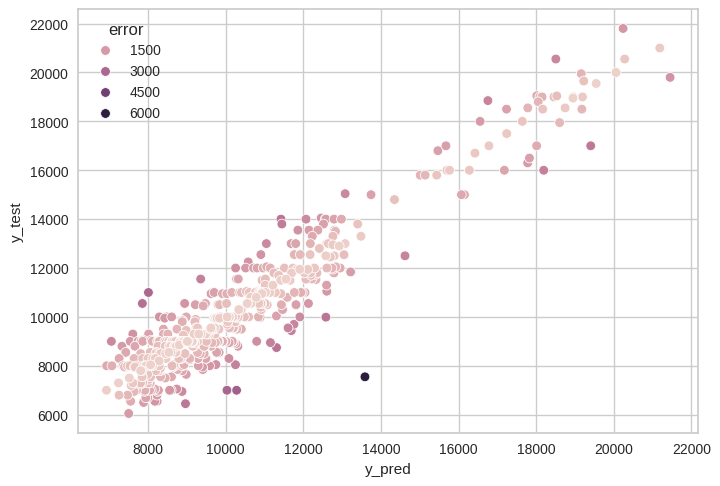

In [27]:
sns.scatterplot(data=pred_df, x="y_pred", y="y_test", hue="error")

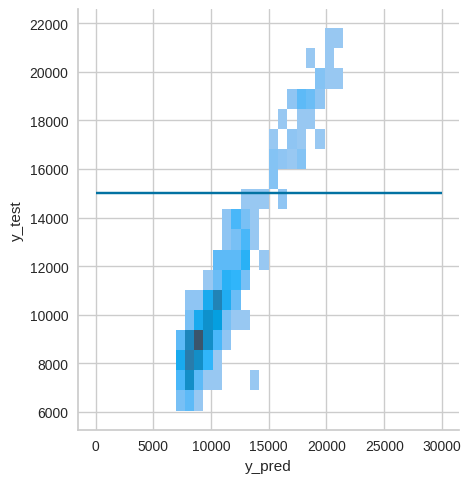

In [28]:
sns.displot(data=pred_df, x="y_pred", y="y_test")
plt.hlines(y = 15000, xmin=0, xmax=30000)

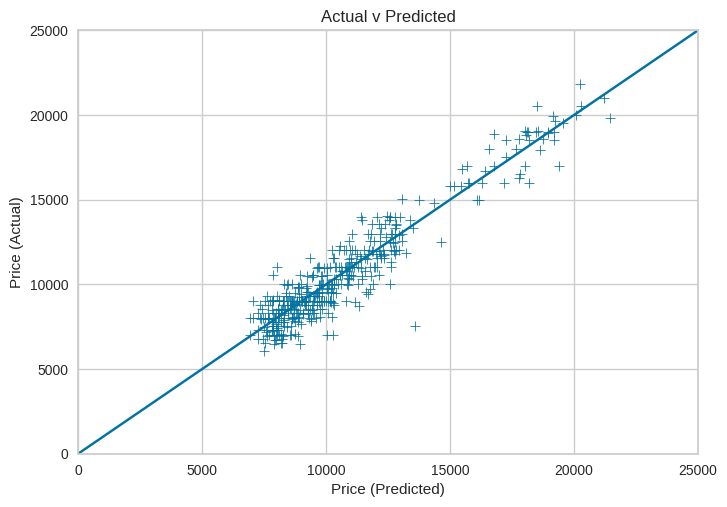

In [29]:
sns.scatterplot(data=pred_df, x="y_pred", y="y_test", marker='+')
plt.ylim(0, 25000)
plt.xlim(0, 25000)
plt.ylabel("Price (Actual)")
plt.xlabel("Price (Predicted)")
plt.title("Actual v Predicted")
plt.plot(list(range(25000)), list(range(25000)))